<a href="https://colab.research.google.com/github/darshlukkad/CRISP-DM_SEMMA_KDD/blob/main/SEMMA_Credit_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📗 SEMMA: Credit Card Default Prediction
We follow **SEMMA**: Sample → Explore → Modify → Model → Assess  
**Dataset**: `uciml/default-of-credit-card-clients-dataset` (Kaggle)

# 🚀 Step 1: One-time Kaggle setup (super easy)
1. Create a free Kaggle account (https://www.kaggle.com/).
2. Go to your Kaggle **Account** → scroll to **API** → click **Create New API Token**.
   - This downloads a file named **`kaggle.json`** to your computer.
3. In Colab, run the next cell. It will ask you to **upload `kaggle.json`**.

In [1]:
# Install and set up Kaggle API
!pip -q install kaggle

import os, zipfile, glob, shutil, json, sys
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# Put kaggle.json in the right place
kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

if not (kaggle_dir / "kaggle.json").exists():
    try:
        from google.colab import files  # will work in Colab
        print("👉 Please upload your kaggle.json (you get it from Kaggle > Account > Create New API Token).")
        uploaded = files.upload()
        assert "kaggle.json" in uploaded, "You must upload a file named kaggle.json"
        with open(kaggle_dir / "kaggle.json", "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(kaggle_dir / "kaggle.json", 0o600)
        print("✅ Installed kaggle.json")
    except Exception as e:
        print("If you're not in Colab, manually place kaggle.json in", kaggle_dir)
        raise e
else:
    print("✅ kaggle.json already present")

👉 Please upload your kaggle.json (you get it from Kaggle > Account > Create New API Token).


Saving kaggle.json to kaggle.json
✅ Installed kaggle.json


# 📥 Step 2: Download the dataset automatically
We will use the Kaggle API to download the dataset into the local `data/` folder.
If (rarely) Kaggle blocks the download, the next cells will let you **manually upload** the CSV instead.

In [2]:
# Download the Kaggle dataset
KAGGLE_DATASET = "uciml/default-of-credit-card-clients-dataset"
print("⏬ Downloading:", KAGGLE_DATASET)
!kaggle datasets download -d $KAGGLE_DATASET -p $DATA_DIR --force

# Unzip any archives into data/
import zipfile, io
for z in DATA_DIR.glob("*.zip"):
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)
    z.unlink()

print("📂 Contents of data/:", [p.name for p in DATA_DIR.iterdir()])

⏬ Downloading: uciml/default-of-credit-card-clients-dataset
Dataset URL: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset
License(s): CC0-1.0
  0% 0.00/0.98M [00:00<?, ?B/s]
100% 0.98M/0.98M [00:00<00:00, 991MB/s]
📂 Contents of data/: ['UCI_Credit_Card.csv']


# 🆘 If needed: Manual upload fallback
If you don't see a CSV in `data/`, run the next cell and upload the CSV from Kaggle manually.
(Go to the dataset page on Kaggle and click **Download** to get the zip; extract the CSV and upload here.)

In [3]:
from pathlib import Path
csvs = list(Path("data").glob("*.csv"))
if not csvs:
    try:
        from google.colab import files
        print("No CSV detected in data/. Please upload the CSV file now.")
        uploaded = files.upload()
        # Save the first uploaded CSV into data/
        for k, v in uploaded.items():
            if k.lower().endswith(".csv"):
                with open(Path("data")/k, "wb") as f:
                    f.write(v)
        print("✅ Uploaded CSV to data/.")
    except Exception as e:
        raise RuntimeError("Still no CSV found. Please upload a CSV to data/.") from e
else:
    print("✅ CSV already present:", [c.name for c in csvs])

✅ CSV already present: ['UCI_Credit_Card.csv']


# 🧰 Step 3: Imports and reproducibility

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import warnings, sys, os, re
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load data and basic checks
Target: **`default.payment.next.month`** (1 = default, 0 = no default)

In [5]:
from pathlib import Path
import pandas as pd

# Auto-detect CSV (usually 'UCI_Credit_Card.csv')
candidates = list(Path("data").glob("*.csv"))
assert candidates, "No CSV found; please ensure the credit dataset CSV is in data/."
csv_path = None
for p in candidates:
    if "UCI" in p.name or "Credit" in p.name or "default" in p.name.lower():
        csv_path = p
        break
if csv_path is None:
    csv_path = candidates[0]

print("Using CSV:", csv_path)
df = pd.read_csv(csv_path)
print(df.head())
print(df.shape)
print(df.isna().sum().sort_values(ascending=False).head(10))

Using CSV: data/UCI_Credit_Card.csv
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.n

## S) Sample
Create train/validation/test splits with class stratification.

In [6]:
from sklearn.model_selection import train_test_split

df2 = df.copy()
y = df2['default.payment.next.month']
X = df2.drop(columns=['default.payment.next.month', 'ID'], errors='ignore')

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)
print("Train/Valid/Test:", X_train.shape, X_valid.shape, X_test.shape)

Train/Valid/Test: (21000, 23) (4500, 23) (4500, 23)


## E) Explore
Look at distributions, correlations, and class balance.

Class balance:
 default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


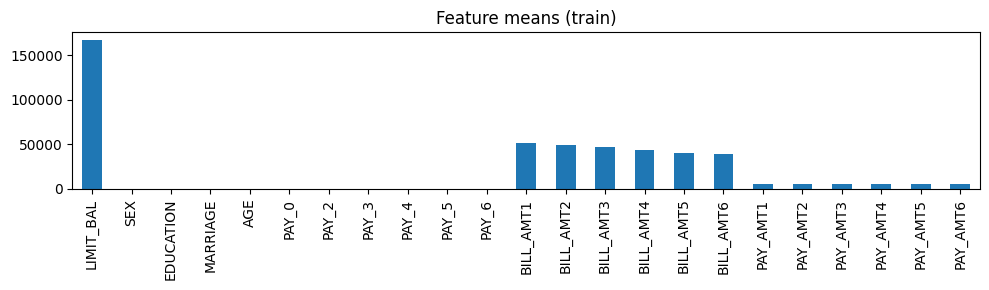

In [7]:
import matplotlib.pyplot as plt

print("Class balance:\n", y.value_counts(normalize=True))

ax = X_train.describe().T['mean'].plot(kind='bar', figsize=(10,3))
plt.title('Feature means (train)')
plt.tight_layout()
plt.show()

## M) Modify
- Scale numeric features
- Optional: Select K best features by mutual information

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = X_train.select_dtypes(include='number').columns.tolist()

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols)
])

selector = SelectKBest(score_func=mutual_info_classif, k=min(15, len(num_cols)))

print("Prepared numeric columns:", len(num_cols))

Prepared numeric columns: 23


## M) Model
Train a simple baseline (Logistic Regression) and a stronger model (Gradient Boosting).

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

logreg = Pipeline([('prep', preprocess),
                   ('sel', selector),
                   ('clf', LogisticRegression(max_iter=400, class_weight='balanced', random_state=RANDOM_STATE))])

gb = Pipeline([('prep', preprocess),
               ('sel', selector),
               ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))])

logreg.fit(X_train, y_train)
gb.fit(X_train, y_train)

def eval_model(model, Xv, yv, name):
    pred = model.predict(Xv)
    proba = model.predict_proba(Xv)[:,1]
    print(f"\n=== {name} VALIDATION ===")
    print(classification_report(yv, pred, digits=3))
    print("ROC-AUC:", roc_auc_score(yv, proba))

eval_model(logreg, X_valid, y_valid, "LogReg")
eval_model(gb, X_valid, y_valid, "GradientBoosting")


=== LogReg VALIDATION ===
              precision    recall  f1-score   support

           0      0.872     0.686     0.768      3505
           1      0.368     0.644     0.468       995

    accuracy                          0.677      4500
   macro avg      0.620     0.665     0.618      4500
weighted avg      0.760     0.677     0.702      4500

ROC-AUC: 0.7132564391142588

=== GradientBoosting VALIDATION ===
              precision    recall  f1-score   support

           0      0.839     0.950     0.891      3505
           1      0.667     0.357     0.465       995

    accuracy                          0.818      4500
   macro avg      0.753     0.653     0.678      4500
weighted avg      0.801     0.818     0.797      4500

ROC-AUC: 0.7764964623402318


## A) Assess (Test Set + Lift Chart)
Pick the better model (often Gradient Boosting) and produce metrics + **lift**.

=== TEST REPORT (Chosen Model) ===
              precision    recall  f1-score   support

           0      0.837     0.946     0.888      3504
           1      0.647     0.350     0.455       996

    accuracy                          0.814      4500
   macro avg      0.742     0.648     0.671      4500
weighted avg      0.795     0.814     0.792      4500

TEST ROC-AUC: 0.775001690552163


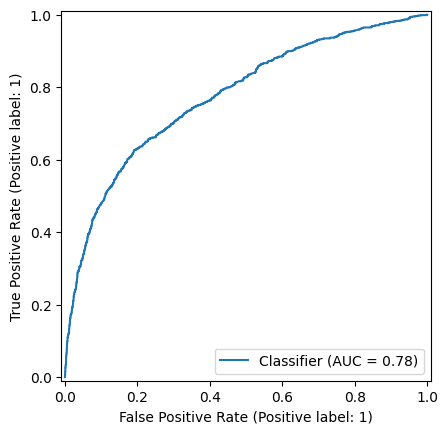

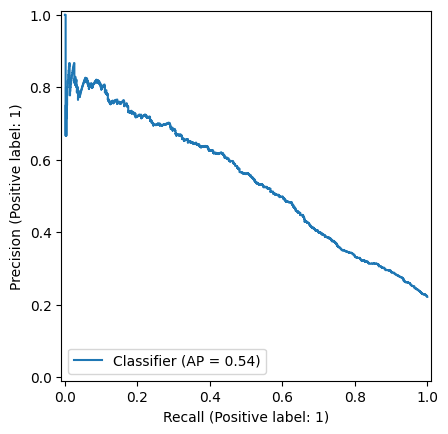

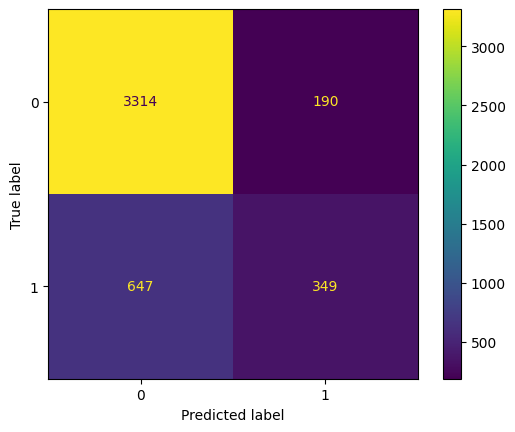

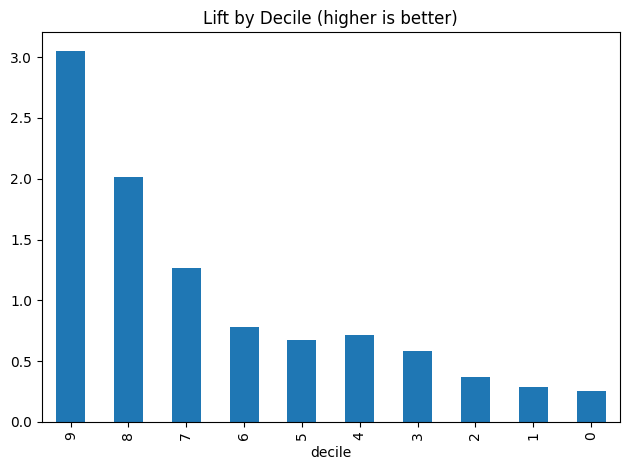

        events  count  event_rate      lift  cum_pct_events
decile                                                     
9          304    450    0.675556  3.052209        0.305221
8          201    450    0.446667  2.018072        0.507028
7          126    450    0.280000  1.265060        0.633534
6           78    450    0.173333  0.783133        0.711847
5           67    450    0.148889  0.672691        0.779116
4           71    450    0.157778  0.712851        0.850402
3           58    450    0.128889  0.582329        0.908635
2           37    449    0.082405  0.372313        0.945783
1           29    451    0.064302  0.290519        0.974900
0           25    450    0.055556  0.251004        1.000000
✅ SEMMA flow complete!


In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best = gb  # switch to logreg if it validated better

y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:,1]

print("=== TEST REPORT (Chosen Model) ===")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=3))
print("TEST ROC-AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Lift chart (deciles)
deciles = pd.qcut(pd.Series(y_proba), 10, labels=False, duplicates='drop')
lift_df = pd.DataFrame({'proba': y_proba, 'y': y_test.values, 'decile': deciles})
agg = lift_df.groupby('decile').agg(events=('y','sum'), count=('y','size')).sort_index(ascending=False)
agg['event_rate'] = agg['events'] / agg['count']
baseline = lift_df['y'].mean()
agg['lift'] = agg['event_rate'] / baseline
agg['cum_events'] = agg['events'].cumsum()
agg['cum_pct_events'] = agg['cum_events'] / agg['events'].sum()

ax = agg['lift'].plot(kind='bar')
plt.title('Lift by Decile (higher is better)')
plt.tight_layout()
plt.show()

print(agg[['events','count','event_rate','lift','cum_pct_events']])
print("✅ SEMMA flow complete!")

---
### 🔍 (Optional) Ask an AI to critique SEMMA stages
> *"Act as a world-renowned authority on SEMMA. Critique my **Sample, Explore, Modify, Model, Assess** artifacts for rigor, sampling bias, variable selection, and lift/profit analysis. Provide a prioritized fix list."*